In this notebook, I will use a linear and tree models. 

The data set will be different from the one used in ARIMA models. An obersvation will containg last weeks expenses, incomes and balance. Hence, I need to compute the balance at each week.
(many other features can be computed, but I will stick to those, I've already spent a lot of time on previous notebooks)

I first split data into train/validate/test sets. Then I train models on train set, predict on validation set, then choose the one that have best results (MAPE and MAE). We can't use a cross validation here, since data should be kept in its chronological order. (This step ois meant to avoid overfitting)

Finally I apply it on the test set. 
I will then compare it to the ARIMA model chosen before.

ARIMA model was trained on 80% against opnly 60% of data for the ones used here. This was necessary to test them both on same data (20% last percents).

I will not spend time on looking for the best parameters here (grid search) due to lack of time. It is more meant to show the options we got.

In [3]:
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np

from typing import Tuple

from datetime import timedelta

import joblib

### Read data

In [4]:
df_accounts = pd.read_csv(
    "../data/accounts_enough_history.csv", parse_dates=["update_date"]
)
df_transactions = pd.read_csv(
    "../data/transactions_enough_history.csv", parse_dates=["date"]
)

In [5]:
df_incomes = df_transactions[df_transactions["amount"] > 0]
df_expenses = df_transactions[df_transactions["amount"] < 0]

### Remove outliers

In [6]:
def get_balance_unique_account(
    df_transactions_unique_account: pd.DataFrame, balance: float
) -> pd.DataFrame:
    """Compute weekly balance using transactions for a unique account."""
    grouped_transactions = (
        df_transactions_unique_account.groupby(["account_id", "date"])["amount"]
        .sum()
        .reset_index()
        .sort_values(by=["date"], ascending=False)
    )
    grouped_transactions["balance"] = round(
        balance - grouped_transactions["amount"].cumsum(), 2
    )

    return grouped_transactions.reset_index(drop=True)

In [7]:
def unique_account_week_resampling(df: pd.DataFrame, account_id: int) -> pd.DataFrame:
    """Resample dates into weeks and sum transactions amounts for a unique account."""
    temp_df = df.sort_values(by="date", ascending=True)[["date", "amount"]]

    temp_df = temp_df.set_index("date", drop=True)

    temp_df = temp_df.resample(DATES_RESAMPLING_RULE).sum().reset_index()
    temp_df["account_id"] = account_id

    return temp_df.reset_index(drop=True)

In [8]:
def remove_outliers_year_aggregation(df: pd.DataFrame) -> pd.DataFrame:
    df["year"] = df["date"].dt.year

    df_month_expenses = (
        df.groupby(["account_id", "year"])["amount"].agg(["mean", "std"]).reset_index()
    )
    df = pd.merge(
        df,
        df_month_expenses,
        on=["account_id", "year"],
        how="left",
        sort=False,
    )
    df["outlier"] = df["amount"] > (df["mean"] + 3 * df["std"])
    return df

In [9]:
df_incomes = remove_outliers_year_aggregation(df=df_incomes)
df_incomes = df_incomes[~df_incomes["outlier"]]

df_expenses["amount"] = abs(df_expenses["amount"])
df_expenses = remove_outliers_year_aggregation(df=df_expenses)
df_expenses = df_expenses[~df_expenses["outlier"]]

<ipython-input-8-e646f9ddc972>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["date"].dt.year
<ipython-input-9-589335085b07>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expenses["amount"] = abs(df_expenses["amount"])
<ipython-input-8-e646f9ddc972>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

### Week resampling

In [10]:
def _resample_per_week_unique_account(df: pd.DataFrame) -> pd.DataFrame:
    """Resample date into weeks for a unique account."""
    account_id = df["account_id"].iloc[0]

    temp_df = df.sort_values(
        by="date", ascending=True
    )[["date", "amount"]]

    temp_df = temp_df.set_index("date", drop=True)

    temp_df = (
        temp_df.resample("W-MON").sum().reset_index()
    )
    temp_df["account_id"] = account_id

    return temp_df


def resample_per_week(df: pd.DataFrame) -> pd.DataFrame:
    """Return a dataframe with resampled data into weeks."""
    transactions_dfs = [data for _, data in df.groupby("account_id")]

    return pd.concat(
        [
            _resample_per_week_unique_account(
                df=df_unique_account,
            )
            for df_unique_account in transactions_dfs
        ]
    ).reset_index(drop=True)

In [11]:
df_expenses = resample_per_week(df=df_expenses)
df_incomes = resample_per_week(df=df_incomes)

### Compute history balance

Since I have already removed outliers from data, the balance is not the real one, but only an estimation using only incomes and expenses kept.

In [12]:
df_expenses["amount"] = df_expenses["amount"] * (-1)

df_transactions = pd.concat([df_incomes, df_expenses], axis=0)

In [13]:
def _get_balance_unique_account(
    df_transactions_unique_account: pd.DataFrame, balance: float, account_id: int
) -> pd.DataFrame:
    """Compute the balance using transactions."""
    grouped_transactions = (
        df_transactions_unique_account.groupby(["account_id", "date"])[
            "amount"
        ]
        .sum()
        .reset_index()
        .sort_values(by=["date"], ascending=False)
    )
    grouped_transactions["balance"] = round(
        balance - grouped_transactions[
        "amount"
    ].cumsum(), 2
    )

    return grouped_transactions


def get_balance_data(df_accounts: pd.DataFrame, df_trans: pd.DataFrame) -> pd.DataFrame:
    """Return a dataframe with history accounts balance."""
    account_dfs = [data for _, data in df_trans.groupby("account_id")]

    return pd.concat(
        [
            _get_balance_unique_account(
                df_transactions_unique_account=df,
                balance=df_accounts[df_accounts["id"] == df["account_id"].iloc[0]][
                    "balance"
                ].iloc[0],
                account_id=df["account_id"].iloc[0],
            )
            for df in account_dfs
        ]
    ).reset_index(drop=True)

In [14]:
df_balance = get_balance_data(df_accounts=df_accounts, df_trans=df_transactions)

In [15]:
df_balance

,account_id,date,amount,balance
0,2,2020-01-20,0.00,3.52
1,2,2020-01-13,-56.00,59.52
2,2,2020-01-06,-73.85,133.37
3,2,2019-12-30,0.00,133.37
4,2,2019-12-23,-78.74,212.11
...,...,...,...,...
2012,49,2019-07-08,1.20,500.75
2013,49,2019-07-01,0.00,500.75
2014,49,2019-06-24,-9.17,509.92
2015,49,2019-06-17,0.00,509.92


### Create final dataset 

In [17]:
df_week_transactions = pd.merge(df_expenses, df_incomes, on=["date", "account_id"], how="left", sort=False, suffixes=["_outgoings", "_incomes"])


In [18]:
df_week_transactions.fillna(0, inplace=True)

In [19]:
df_week_transactions = pd.merge(df_week_transactions, df_balance[["date", "balance", "account_id"]], on=["account_id", "date"], how="left", sort=False)


In [20]:
df_week_transactions

,date,amount_outgoings,account_id,amount_incomes,balance
0,2017-05-29,-5.90,2,2300.0,-9335.05
1,2017-06-05,-2293.69,2,0.0,-7040.95
2,2017-06-12,-0.00,2,0.0,-9334.64
3,2017-06-19,-5.90,2,0.0,-9334.64
4,2017-06-26,-0.00,2,123.0,-9340.54
...,...,...,...,...,...
2000,2019-12-09,-10.80,49,0.0,60.44
2001,2019-12-16,-0.00,49,0.0,49.64
2002,2019-12-23,-0.00,49,0.0,49.64
2003,2019-12-30,-0.00,49,0.0,49.64


In [21]:
def _create_windows_unique_account(
    df: pd.DataFrame, max_empty_weeks: int
) -> pd.DataFrame:
    """Removes windows that have more than `max_empty_weeks` empty weeks for a unique account."""
    # Expense
    for i in range(1, 13):
        df[f"previous_outgoings_{i}"] = df["amount_outgoings"].shift(i, fill_value=0)
    for i in range(1, 13):
        df[f"previous_incomes_{i}"] = df["amount_incomes"].shift(i, fill_value=0)
    for i in range(1, 12):  # Only to 11, since the actual balance is the one from the beginning of the week
        df[f"previous_balance_{i}"] = df["amount_incomes"].shift(i, fill_value=0)   

    return df[(df[[col for col in df.columns if 'expense' in col]] == 0).sum(1) < max_empty_weeks]


def create_windows(df: pd.DataFrame, max_empty_weeks: int) -> pd.DataFrame:
    """Removes windows that have more than `max_empty_weeks` empty weeks."""
    transactions_dfs = [data for _, data in df.groupby("account_id")]

    return pd.concat(
        [
            _create_windows_unique_account(
                df=df_unique_account, max_empty_weeks=max_empty_weeks
            )
            for df_unique_account in transactions_dfs
        ]
    ).reset_index(drop=True)

In [22]:
df_final = create_windows(df=df_week_transactions, max_empty_weeks=6)
df_final.head(2)

,date,amount_outgoings,account_id,amount_incomes,balance,previous_outgoings_1,previous_outgoings_2,previous_outgoings_3,previous_outgoings_4,previous_outgoings_5,...,previous_balance_2,previous_balance_3,previous_balance_4,previous_balance_5,previous_balance_6,previous_balance_7,previous_balance_8,previous_balance_9,previous_balance_10,previous_balance_11
0,2017-05-29,-5.90,2,2300.0,-9335.05,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-06-05,-2293.69,2,0.0,-7040.95,-5.9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Split TRAIN / VALIDATION / TEST

In [23]:
def split_train_validation_test(
    df: pd.DataFrame, ratio_train: float, ratio_validation: float
) -> Tuple[pd.DataFrame]:
    """
    Return a tuple of 3 DataFrames containing train, validation and test sets.
    The split must respect the chronological order.
    """
    dfs_train = []
    dfs_validation = []
    dfs_test = []

    for account_id in df["account_id"].unique():
        df_temp = (
            df[df["account_id"] == account_id]
            .sort_values(by="date")
            .reset_index(drop=True)
        )
        index_train, index_validation = int(len(df_temp) * ratio_train), int(
            len(df_temp) * (ratio_validation + ratio_train)
        )
        dfs_train.append(df_temp[:index_train])
        dfs_validation.append(df_temp[index_train:index_validation])
        dfs_test.append(df_temp[index_validation:])

    return (
        pd.concat(dfs_train, ignore_index=True),
        pd.concat(dfs_validation, ignore_index=True),
        pd.concat(dfs_test, ignore_index=True),
    )


df_train, df_validate, df_test = split_train_validation_test(
    df=df_final, ratio_train=0.6, ratio_validation=0.2
)

## Models

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor

def mean_absolute_percentage_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (
        np.mean(
            np.abs((y_true - y_pred) / y_true)[
                np.isfinite(np.abs((y_true - y_pred) / y_true))
            ]
        )
        * 100
    )


In [25]:
y_train = df_train["amount_outgoings"]
X_train = df_train.drop(["amount_outgoings", "date", "amount_incomes", "account_id"], axis=1)

y_val = df_validate["amount_outgoings"]
X_val = df_validate.drop(["amount_outgoings", "date", "amount_incomes", "account_id"], axis=1)

In [26]:
lin_reg = LinearRegression().fit(X_train, y_train)

In [27]:
y_val_pred = lin_reg.predict(X_val)
positive_mask = y_val_pred > 0
y_val_pred[positive_mask] = 0
median_absolute_error(y_val_pred, y_val)

309.4085176751912

By computing incomes and balance features and applying a simple linear regression , we obtain a median absolute error higher than the one obtained using ARIMA model. 


In [28]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_val_pred = xgb.predict(X_val)
positive_mask = y_val_pred > 0
y_val_pred[positive_mask] = 0
median_absolute_error(y_val_pred, y_val)

310.7833587646485

NB: I had a better result before, and it is to late to change everything, so I kept the xgboost regressor.

The XGB performs better. It would be appropriate to test other models and parameters (gridsearch), but due to lack of time I will go forward with a classic XGBoost and its defaults parameters.

- An other improvement would be to add other features:
    - moving average
    - datetime features (week number in the the month [1, 2, 3, 4])
    - statistical metrics (median, quantiles, std...)

### Apply model on test set 

In [32]:
y_test = df_test["amount_outgoings"]
X_test = df_test.drop(["amount_outgoings", "date", "amount_incomes", "account_id"], axis=1)

In [33]:
xgb = XGBRegressor()
#xgb.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))
xgb.fit(X_train, y_train)
y_test_pred = xgb.predict(X_test)
median_absolute_error(y_test_pred, y_test)

293.7488430786133

### Save the trained model

In [34]:
# save the model to disk
filename = 'xgb_model.sav'
joblib.dump(xgb, filename)
 
# load the model from disk
loaded_model = joblib.load(filename)
y_test_pred = loaded_model.predict(X_test)
positive_mask = y_test_pred > 0  # Where values are low
y_test_pred[positive_mask] = 0

median_absolute_error(y_test_pred, y_test)

293.7488430786133

In [38]:
np.arange(-10000, -1)

array([-10000,  -9999,  -9998, ...,     -4,     -3,     -2])

Text(0.5, 1.0, 'Predictions against real target')

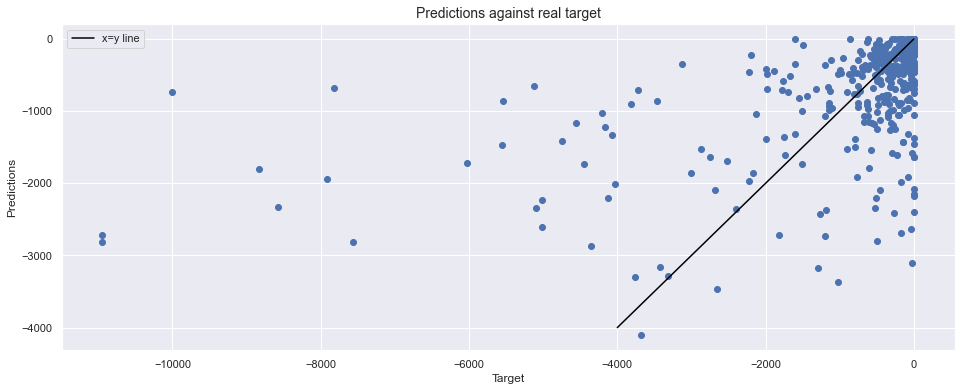

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(16, 6))
plt.scatter(y_test, y_test_pred)
plt.plot(np.arange(-4000, -1), np.arange(-4000, -1), 'black', label="x=y line")
plt.xlabel("Target")
plt.ylabel("Predictions")
plt.legend()
plt.title("Predictions against real target", fontsize=14)

In [50]:
import numpy as np

FLOAT_FORMAT = "{:.2f}"


def plot_quantiles(
    values: np.ndarray, quantiles: list, name: str
) -> pd.DataFrame:
    columns_names = [FLOAT_FORMAT.format(quantile) for quantile in quantiles]
    return pd.DataFrame(
        data=np.quantile(values, quantiles, interpolation="linear"),
        index=columns_names,
        columns=[f"{name}_quantiles"],
    )


QUANTILES = [0.05 * i for i in range(1, 20)]

target_quantiles = plot_quantiles(
    values=y_test, quantiles=QUANTILES, name="target"
)

mae_quantiles = plot_quantiles(
    values=abs(y_test_pred - y_test), quantiles=QUANTILES, name="model_MAE"
)

def absolute_percentage_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (
            np.abs((y_true - y_pred) / y_true)[
                np.isfinite(np.abs((y_true - y_pred) / y_true))
            ]
        * 100
    )
mape_errors = absolute_percentage_error(y_test, y_test_pred)
mape_quantiles = plot_quantiles(
    values=[x for x in mape_errors if x == x], quantiles=QUANTILES, name="model_MAPE"
)


pd.concat([target_quantiles, mae_quantiles, mape_quantiles], axis=1)

,target_quantiles,model_MAE_quantiles,model_MAPE_quantiles
0.05,-4140.4150,15.109157,10.257410
0.10,-2196.4610,36.891392,17.283926
0.15,-1502.7685,60.532035,26.226614
0.20,-945.2440,90.026097,34.896917
0.25,-698.5000,117.794484,42.129870
0.30,-563.5930,150.090708,50.079574
0.35,-475.4415,186.170128,56.643781
0.40,-377.6260,216.467091,69.253500
0.45,-322.7875,253.260888,74.316653
0.50,-263.9450,293.748843,78.444728


Results here are not satisfying. For 40% of data, our predictions have more than 100% MAPE -> The error is twice higher than the real value.

Many work has to be done in preprocessing data (I made some suggestions in the notebooks)